# Import required packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Mon May 04 2020 

numpy 1.18.1
scipy 1.4.1
pomegranate 0.11.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


# Data Preprocessing

In [2]:
df =  pd.read_csv(r'D:\Studies\Corona Research\owid-covid-data_1_may.csv', encoding = 'utf8')
countries = ['Australia', 'Switzerland', 'China', 'India', 'Iceland',
       'South Korea', 'New Zealand','Austria'] #unordered list of countries
df = df[df['countriesAndTerritories'].isin(countries)]
df.head()

,geoId,countriesAndTerritories,dateRep,total_cases,cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
673,AUS,Australia,31-12-2019,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
674,AUS,Australia,01-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
675,AUS,Australia,02-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
676,AUS,Australia,03-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
677,AUS,Australia,04-01-2020,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


### Converting the string of dates into datetime object and trimming cases with 0 confirmed cases from the beginning of the data

In [3]:
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%d-%m-%Y')
    return datetime_object.date()

Dates= df.apply(lambda row: date_conversion(row.dateRep), axis = 1)
df.insert(3,'Dates',Dates)
df.drop('dateRep',axis =1,inplace=True)
df_new = df[df['total_cases']>0].copy()
df_new.head()

,geoId,countriesAndTerritories,Dates,total_cases,cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
698,AUS,Australia,2020-01-25,1,1,0,0,0.039,0.039,0.0,0.0,NaN,NaN,NaN,NaN,NaN
699,AUS,Australia,2020-01-26,4,3,0,0,0.157,0.118,0.0,0.0,NaN,NaN,NaN,NaN,NaN
700,AUS,Australia,2020-01-27,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
701,AUS,Australia,2020-01-28,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
702,AUS,Australia,2020-01-29,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN


## Getting the cumulative number of days

In [4]:
country_list = list(df['countriesAndTerritories'].unique()) #to ensure the order of the countries
def get_first_day(country_list,df):
    f_day = []
    for i in country_list:
        first_day = df.loc[df[df['countriesAndTerritories']==i].index[0]].Dates
        f_day.append(first_day)
    return f_day
first_occurence = get_first_day(country_list, df_new)

def cumulative_day(country, Dates, first_occurence,country_list):
    val = (Dates - first_occurence[country_list.index(country)]).days + 1
    return val

In [5]:
# cum_day('China',first_occurence[0],first_occurence, country_list)
cum_day = df_new.apply(lambda row: cumulative_day(row.countriesAndTerritories,row.Dates,first_occurence, country_list), axis = 1)
df_new.insert(3, 'cum_day',cum_day)
df_new.head()

,geoId,countriesAndTerritories,Dates,cum_day,total_cases,cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
698,AUS,Australia,2020-01-25,1,1,1,0,0,0.039,0.039,0.0,0.0,NaN,NaN,NaN,NaN,NaN
699,AUS,Australia,2020-01-26,2,4,3,0,0,0.157,0.118,0.0,0.0,NaN,NaN,NaN,NaN,NaN
700,AUS,Australia,2020-01-27,3,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
701,AUS,Australia,2020-01-28,4,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
702,AUS,Australia,2020-01-29,5,4,0,0,0,0.157,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
#Removing the abonormal datapoint for China
df_new.drop(df_new[(df_new['countriesAndTerritories']=='China') & (df_new['cases']==15141)].index, axis = 0, inplace=True)

# EDA

In [7]:
def barplot(country):
    plt.figure(figsize=(16,8))
    ax= sns.barplot(x= "cum_day", y = "cases", data = df_new[df_new['countriesAndTerritories']==country],palette='binary_r')
    ax.set(xlabel='Days', ylabel='Number of incoming cases')
    plt.title('Barplot of '+ country)

#     plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' barplot.png',dpi = 500)

    plt.show()

In [8]:
def distplot(country):
    plt.figure(figsize=(16,8))
    ax = sns.distplot(df_new[df_new['countriesAndTerritories']==country].cases,color='k')
    ax.set(xlabel = 'Cases', ylabel = 'Proportion')
    plt.title('Distplot of '+ country)

#     plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' distplot.png',dpi = 500)
    plt.show()

# Model Selection

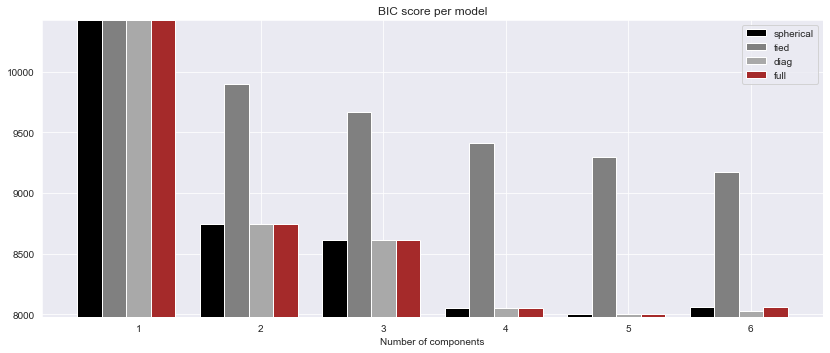

In [9]:
cases_counts = df_new.cases
day = df_new.cum_day
X = np.reshape(np.array(cases_counts),(-1,1))
np.random.seed(0)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['black', 'grey', 'darkgrey',
                              'brown'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(14,12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

In [10]:
def plot_results(country):
    plt.figure(figsize=(16,4))
    plt.scatter(df_new[df_new['countriesAndTerritories']==country].cum_day,df_new[df_new['countriesAndTerritories']==country].cases,
            c=df_new[df_new['countriesAndTerritories']==country].Stages)
    plt.title('Day-wise Counts and Stages for '+country) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Counts')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
#     plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ ' +country+' counts and stages.png',dpi = 500)
    plt.show()


In [11]:
def clustervsstages(country):
    plt.figure(figsize=(16,4))
    plt.scatter(df_new[df_new['countriesAndTerritories']==country].cum_day,df_new[df_new['countriesAndTerritories']==country].Stages,
            c=df_new[df_new['countriesAndTerritories']==country].Stages)
    plt.title('Day-wise stages for '+country) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Stages')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
#     plt.savefig('D:\Studies\Corona Research\Plots\Daywise Stages\ ' +country+' daywise stages.png',dpi = 500)
    plt.show()


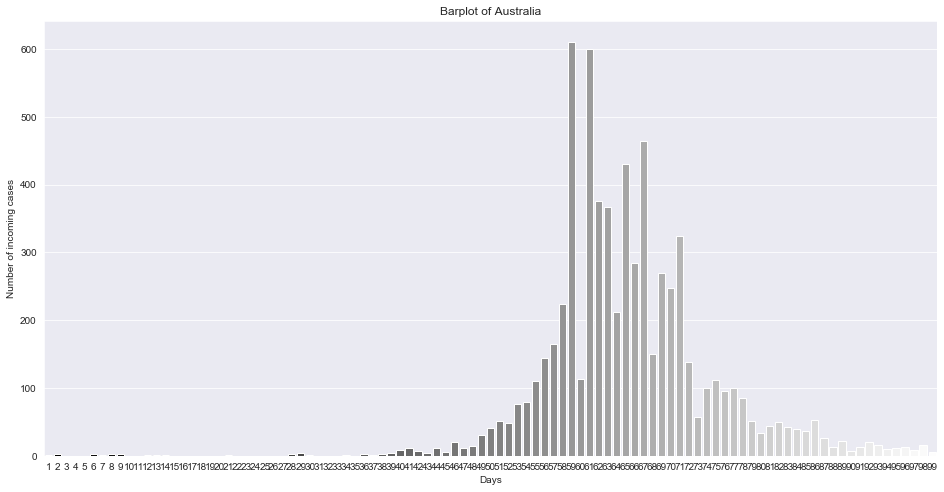

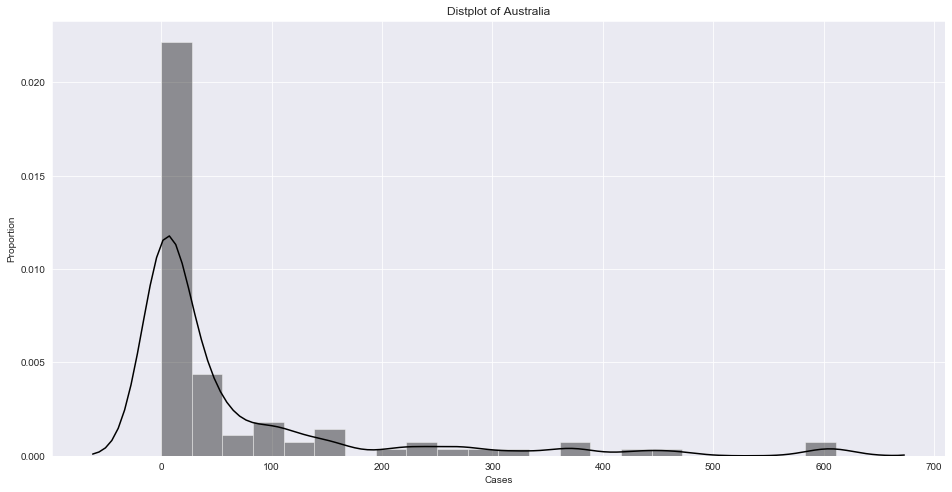

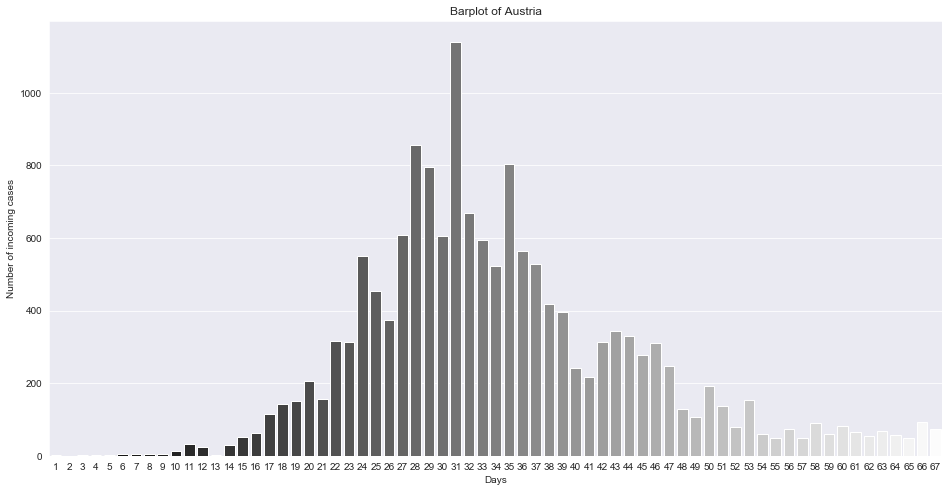

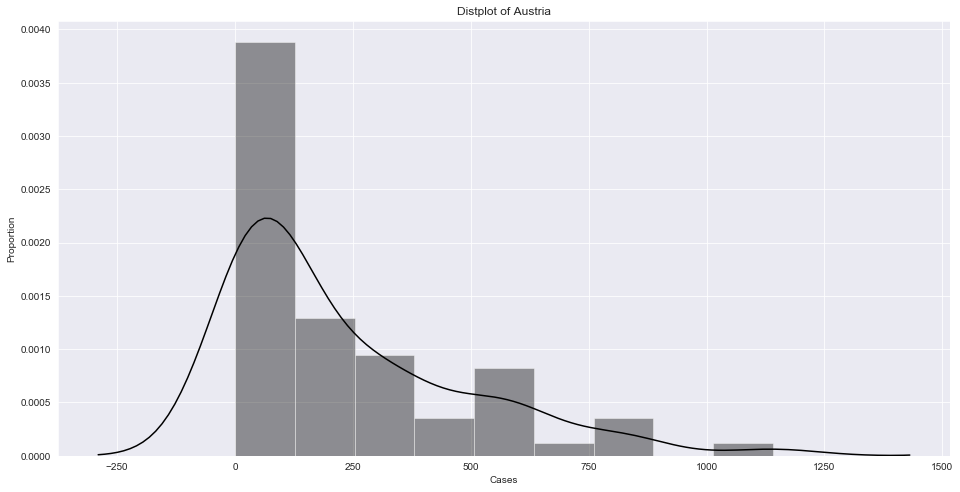

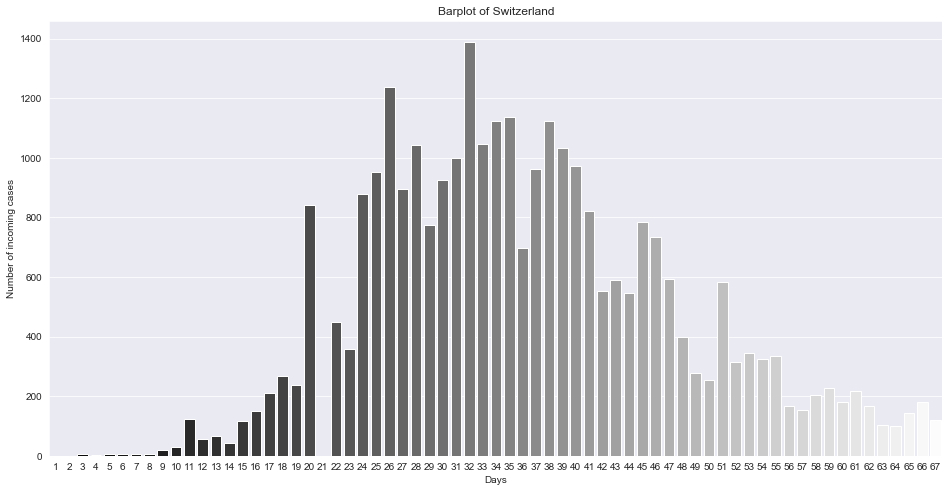

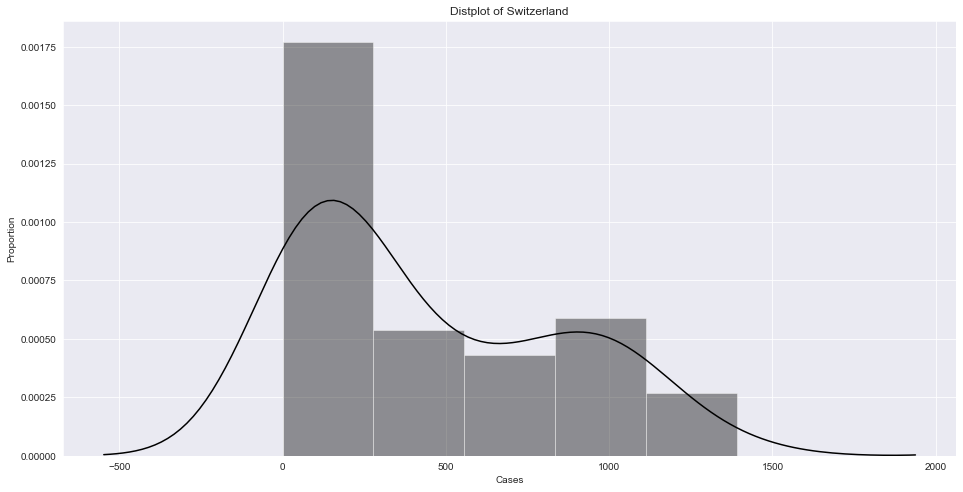

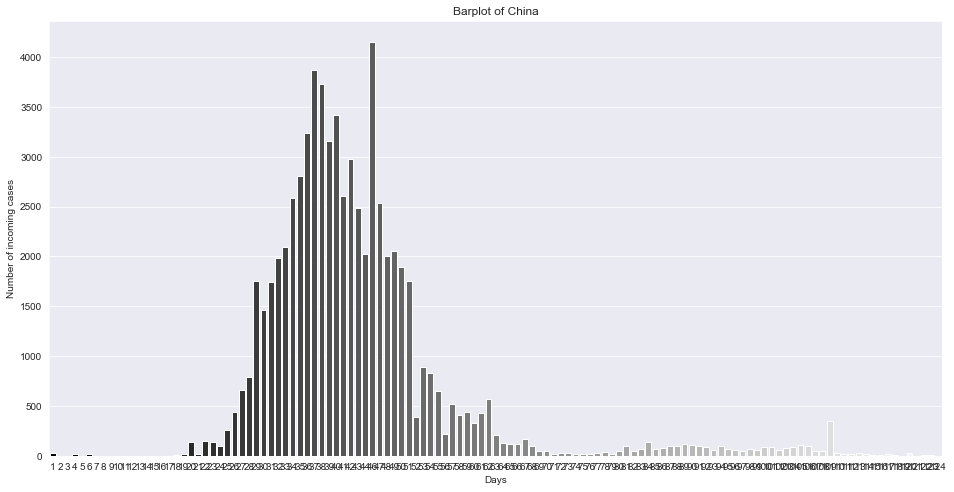

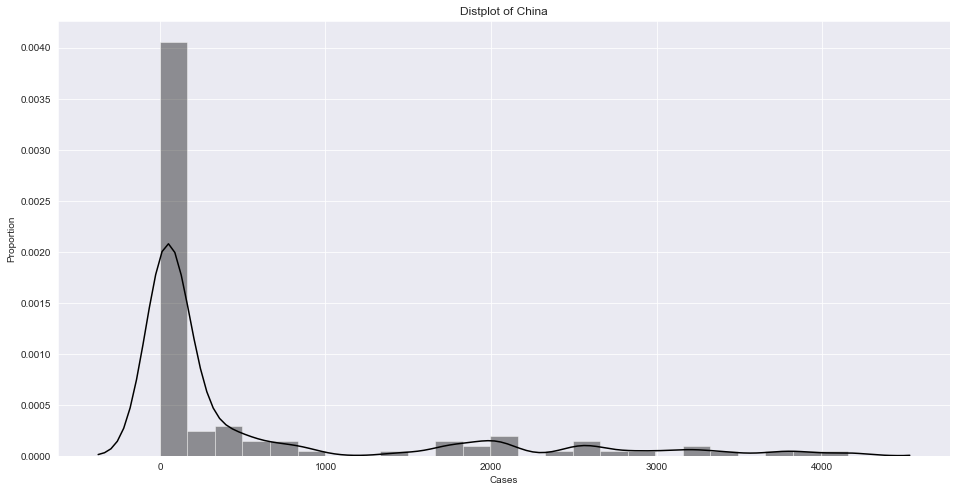

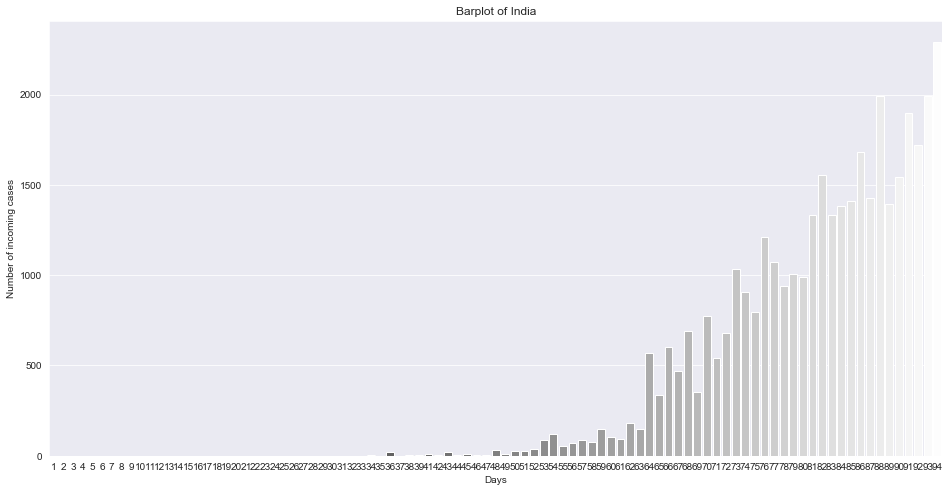

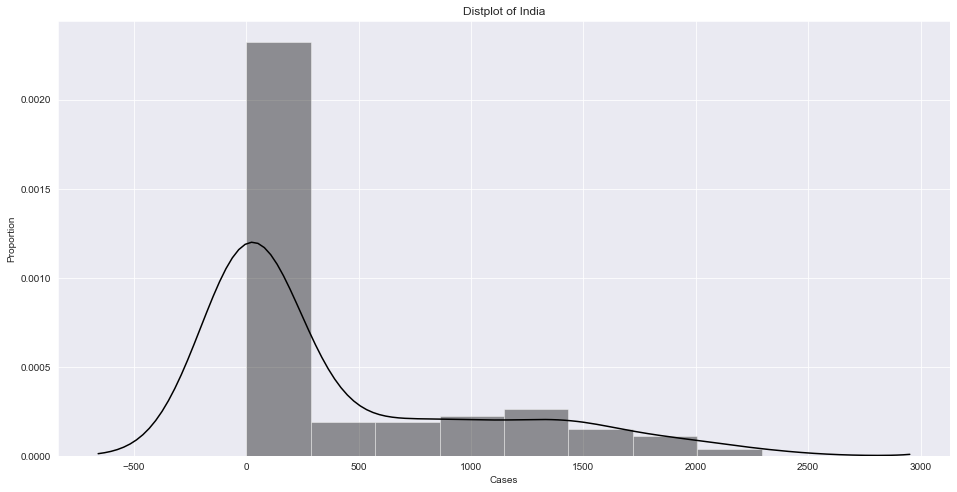

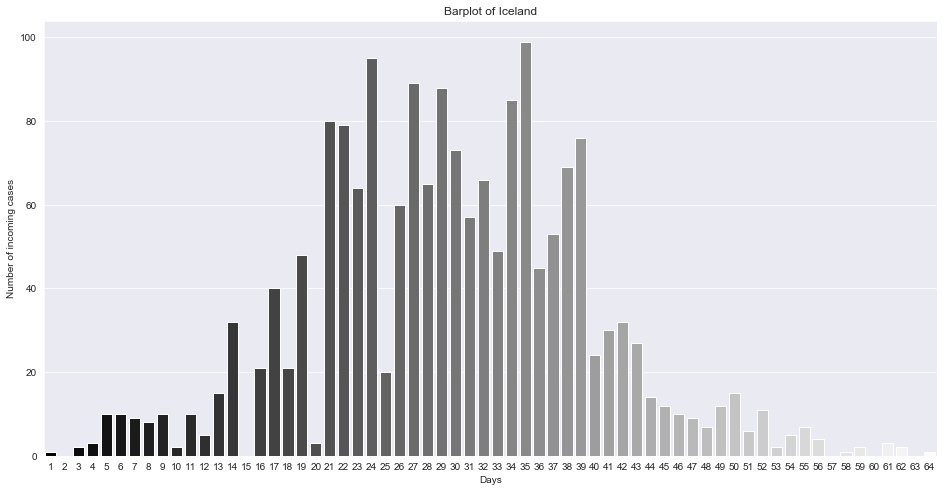

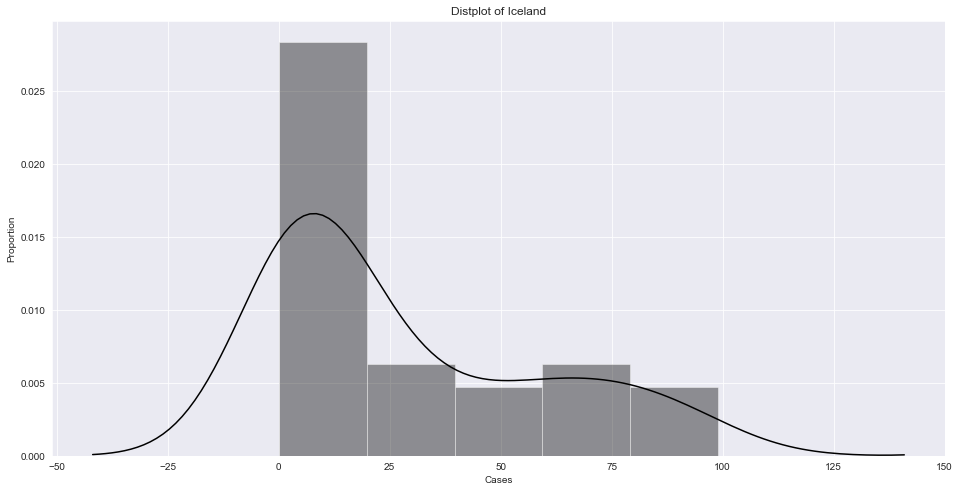

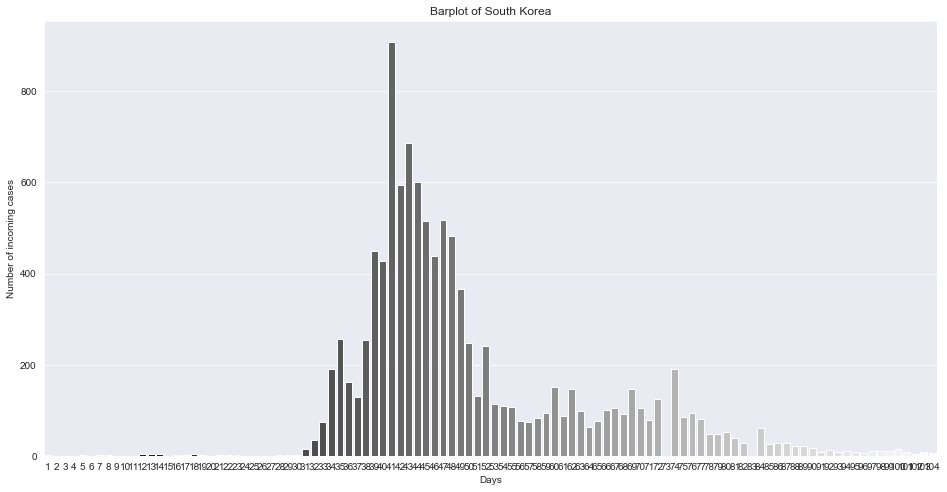

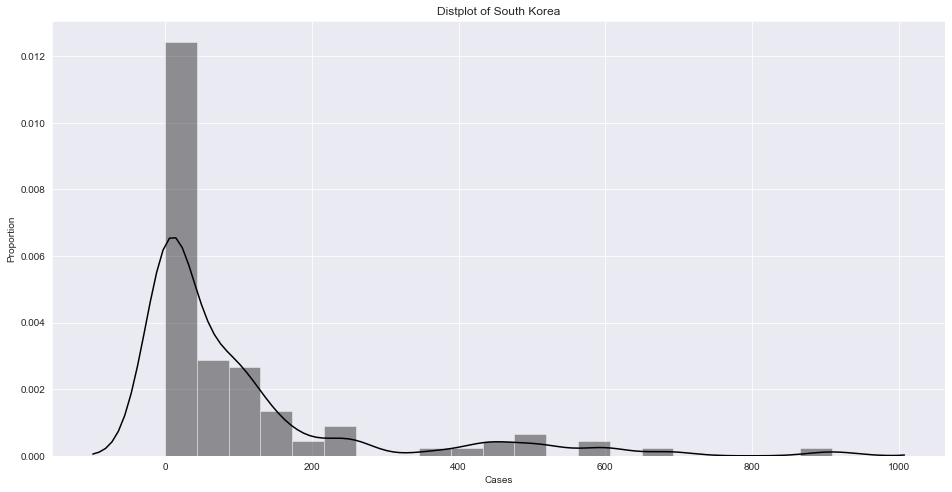

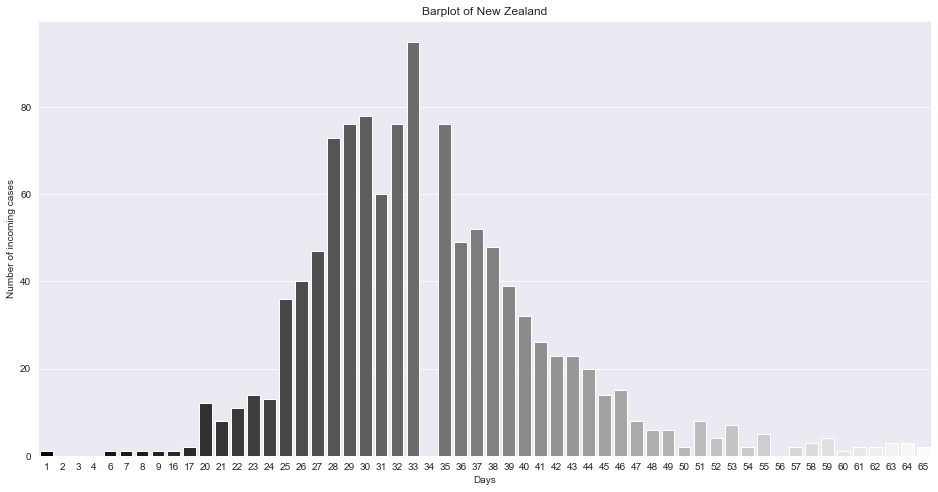

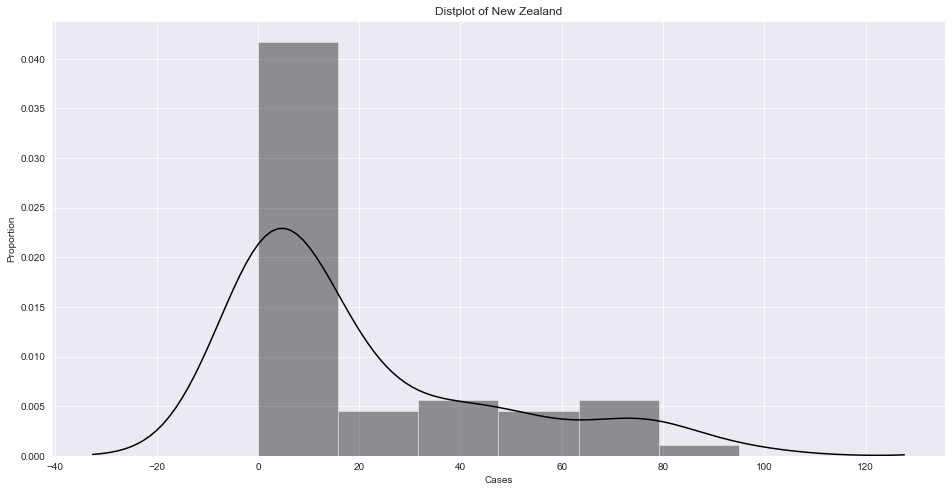

In [12]:
for _ in country_list:
#     plot_results(_)
#     clustervsstages(_)
    barplot(_)
    distplot(_)


# Determining the outbreak

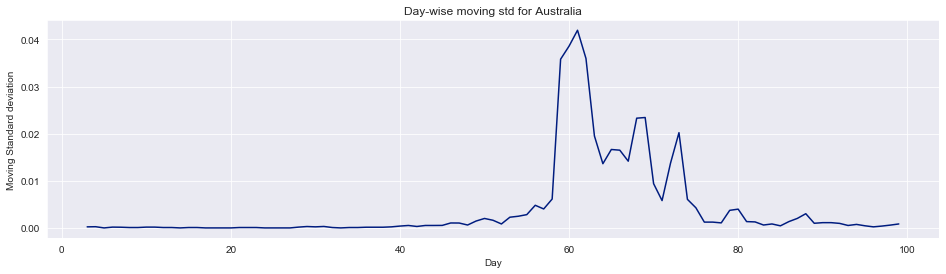

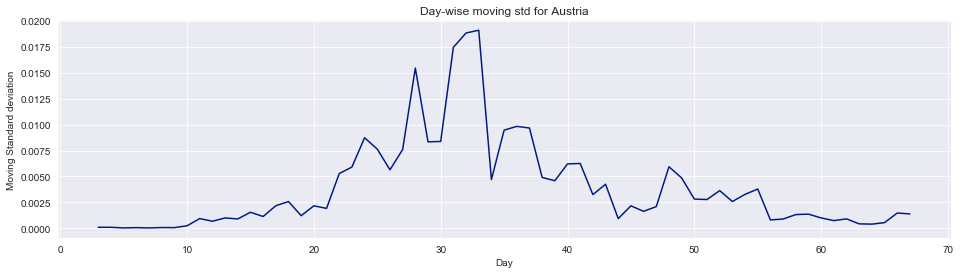

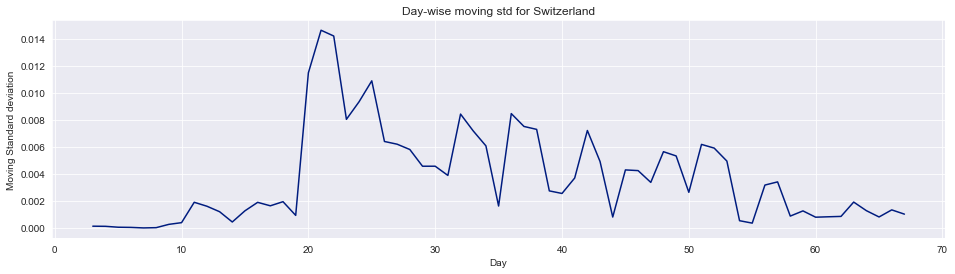

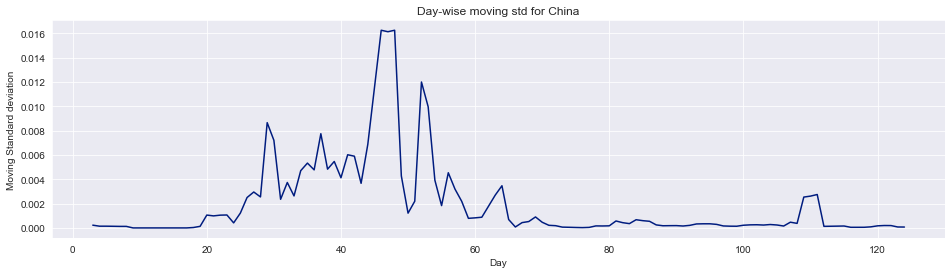

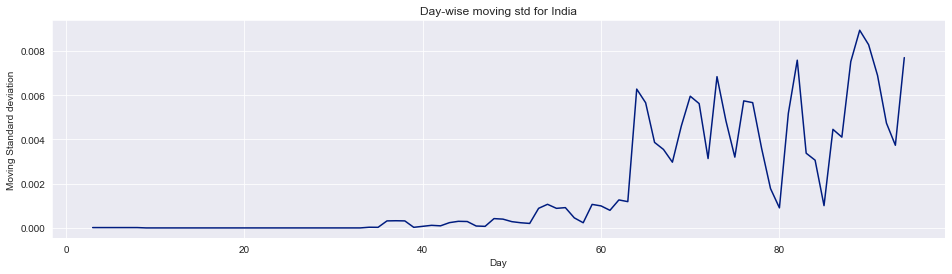

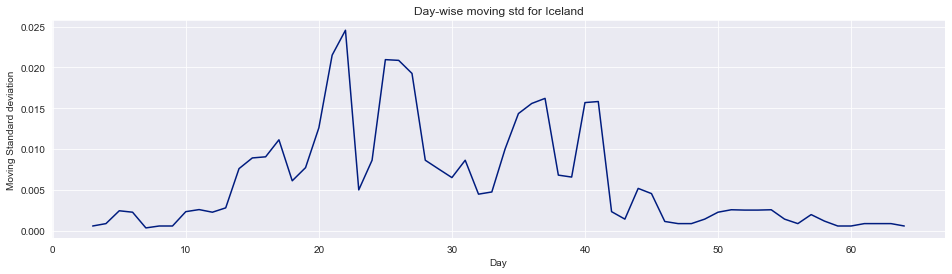

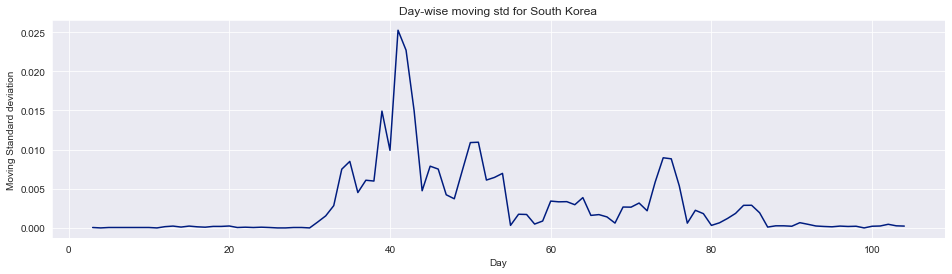

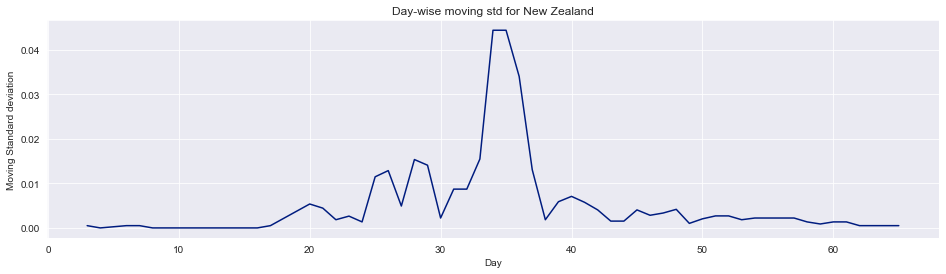

In [13]:
df_std = df_new.copy()
rol = []

for item in country_list:
    normalised_std = df_std[df_std['countriesAndTerritories']==item].cases/(df_std[df_std['countriesAndTerritories']==item].cases.sum())

    rol.extend(normalised_std.rolling(3).std())

df_std['rolling_std']=rol
df_std.drop(df_std[df_std.rolling_std.isna()==True].index,inplace=True)
for item in country_list:
    plt.figure(figsize=(16,4))
    plt.plot(df_std[df_std['countriesAndTerritories']==item].cum_day,df_std[df_std['countriesAndTerritories']==item].rolling_std)
    plt.title('Day-wise moving std for '+item) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Moving Standard deviation')
#     cbar = plt.colorbar()
#     cbar.set_label('Stages')
    plt.savefig('D:\Studies\Corona Research\Plots\Dev_ins\ ' +item+' moving std.png',dpi = 500)
    plt.show()

In [27]:
#Filtering the data based on the threshold for the outbreak
df_training = df_std[df_std['rolling_std']>=0.001]
#Determines the cumulative day since outbreak
df_training.drop(['cum_day'],axis =1,inplace=True)
days_since_outbreak = df_training.apply(lambda row: cumulative_day(row.countriesAndTerritories,row.Dates,get_first_day(country_list, df_training), country_list), axis = 1)
df_training.insert(3, 'days_outbreak',days_since_outbreak)

C:\Users\SHWETANK\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
#Function to fit GMM and Poisson Mixture Model and generate the components
def groupby_generator(n_mixtures,df):
    data_list = []

    input_data =  np.reshape(np.array(df.cases),(-1,1))
    input_data_gmm = pd.concat([df.days_outbreak, df.cases], axis =1)
    gmm = mixture.GaussianMixture(n_components=n_mixtures,covariance_type='full')
    gmm.fit(input_data_gmm)
    means=gmm.means_
    d1 = PoissonDistribution(means[0][1])
    d2 = PoissonDistribution(means[1][1])
    d3 = PoissonDistribution(means[2][1])
    d4 = PoissonDistribution(means[3][1])
    model = GeneralMixtureModel([d1,d2,d3,d4])
    model.fit(input_data)
    return model

#Generated output based on the trained model
def output_generator(n_mixtures,model,input_data):
    
    sequence = model.predict(input_data)
    unique_elements, counts_elements = np.unique(sequence, return_counts=True)
    model.clear_summaries()
    para = []
    for i in range(n_mixtures):
        para.append(model.distributions[i].parameters)

#for getting the stages based on the components             
        
    rank = rankdata(para, method='ordinal')
    stages = []
    for _ in range(len(sequence)):
        if sequence[_]==0:
            stages.append(rank[0])
            continue
        elif sequence[_]==1:
            stages.append(rank[1])
            continue
        elif sequence[_]==2:
            stages.append(rank[2])
            continue
        else:
            stages.append(rank[3])
        
    data_list = [(para),list(zip(unique_elements,counts_elements)),stages, sequence]
#     dicti[country_list[j]] =data_list
    return data_list


In [16]:
def transition_matrix(arr, n=1):
    """"
    Computes the transition matrix from Markov chain sequence of order `n`.

    :arr: Discrete Markov chain state sequence in discrete time with states in 0, ..., N
    :param n: Transition order
    """

    M = np.zeros(shape=(max(arr) , max(arr) ))
    for (i, j) in zip(arr, arr[1:]):
        M[i-1, j-1] += 1

    T = (M.T / M.sum(axis=1)).T

    return np.linalg.matrix_power(T, n)

In [17]:
df_training = df_training[~df_training['countriesAndTerritories'].isin(['India'])].groupby(['days_outbreak']).sum()
df_training.reset_index(inplace=True)
trained_model = groupby_generator(4,df_training)
prediction_data_group =  np.reshape(np.array(df_training.cases),(-1,1))
output_data_group = output_generator(4,trained_model,prediction_data_group)
df_training['Stages_g']=output_data_group[2]
tpm_group = transition_matrix(df_training.Stages_g)

In [19]:
tpm_group

array([[0.86956522, 0.13043478, 0.        , 0.        ],
       [0.21428571, 0.64285714, 0.07142857, 0.07142857],
       [0.        , 0.16666667, 0.75      , 0.08333333],
       [0.        , 0.        , 0.2       , 0.8       ]])

In [20]:
np.linalg.matrix_power(tpm_group,30)

array([[0.40418717, 0.23880859, 0.19442932, 0.16257492],
       [0.39232839, 0.23755257, 0.2018308 , 0.16828824],
       [0.37898682, 0.23614059, 0.21015783, 0.17471476],
       [0.36632558, 0.23479795, 0.21806005, 0.18081643]])

In [32]:
np.linalg.matrix_power(tpm_group,50)

array([[0.39129899, 0.23744365, 0.2024733 , 0.16878406],
       [0.390086  , 0.23731519, 0.20323037, 0.16936844],
       [0.38872143, 0.23717068, 0.20408205, 0.17002584],
       [0.38742622, 0.23703352, 0.20489044, 0.17064983]])

In [22]:
def first_passage_time(tpm,init_state):
    step_1 = np.delete(tpm,init_state-1,1)
    step_2 = np.delete(step_1,init_state-1,0)
    a = step_2-np.identity(step_1.shape[1])
    b = -1*np.ones(step_2.shape[0])
    val = np.linalg.solve(a,b)
    return val
    
    

In [23]:
first_passage_time(tpm_group,1)

array([12. , 20.5, 25.5])

In [24]:
first_passage_time(tpm_group,2)

array([ 7.66666667,  8.5       , 13.5       ])

In [25]:
first_passage_time(tpm_group,3)

array([28.66666667, 21.        ,  5.        ])

In [26]:
first_passage_time(tpm_group,4)

array([38.41666667, 30.75      , 24.5       ])